## UCI DRUG REVIEW DATASET - SENTIMENT ANALYSIS USING KERAS

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## EDA

In [2]:
df = pd.read_csv("drugsComTrain_raw.csv") 

In [3]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null int64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [5]:
list(df)

['Unnamed: 0',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

In [6]:
conditions = df.condition.value_counts().sort_values(ascending=False)
conditions[:10]
#I stole this from a man and really liked it 

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

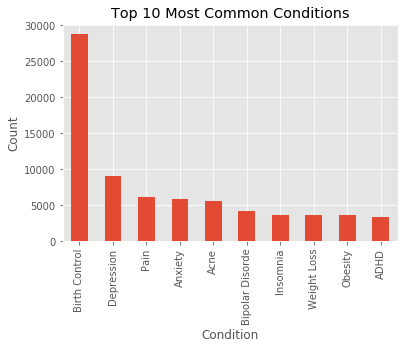

In [7]:
conditions[:10].plot(kind='bar')
plt.title('Top 10 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');
#graph for this

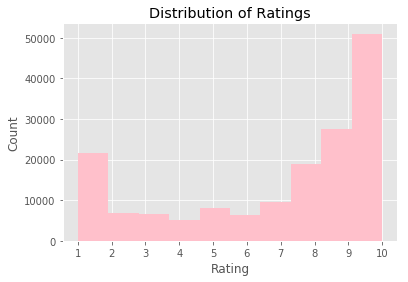

In [10]:
# Look at bias in review (also shown on 'Data' page in competition: distribution of ratings)
df.rating.hist(color='pink')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);
#theres lots of 10's and 1's, people tend to go to extremes or to 5

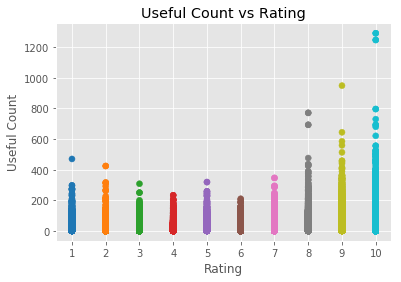

In [12]:
# Is rating correlated with usefulness of the review?
plt.scatter(df.rating, df.usefulCount, c=df.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)]);

In [ ]:
#this tels me that maybe it would be best to drop those three in the middle 

In [13]:
#check for nulls
df.isnull().sum()

Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [14]:
#fill in 'Missing' for null values 
#reason: because theres a lot of them and those nulls are still valuable 
df['condition'].fillna('Missing', inplace = True)

In [15]:
df.isnull().sum()

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [16]:
sid = SentimentIntensityAnalyzer()

In [18]:
# Create list (cast to array) of compound polarity sentiment scores for reviews
sentiments = []

for i in df.review:
    sentiments.append(sid.polarity_scores(i).get('compound'))
    
sentiments = np.asarray(sentiments)

In [20]:
sentiments

array([-0.296 ,  0.8603,  0.7645, ..., -0.743 ,  0.6197,  0.6124])

In [21]:
#make new 'target' column where positive are rating 6-10, negative are rating 1-5
df['target'] = np.where(df['rating']>=6, 1, 0)

In [22]:
y = df.target
x = df.drop(['target','rating'], axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state = 42)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk

In [34]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),lowercase=True, max_features=5000)
#vectorizer = TfidfVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, max_features=5000)
X_onehot = vectorizer.fit_transform(X_train)
stop_words = vectorizer.get_stop_words()
print(type(X_onehot))

<class 'scipy.sparse.csr.csr_matrix'>


In [35]:
print(X_onehot.shape)
print(X_onehot.toarray())

(161297, 5000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [36]:
names_list = vectorizer.get_feature_names()
names = [[i] for i in names_list]
names = Word2Vec(names, min_count=1)
print(len(list(names.wv.vocab)))
print(list(names.wv.vocab)[:5])

W0724 14:44:59.044453 4407289280 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


5000
['00', '000', '00am', '00pm', '01']


In [38]:
from keras.models import Sequential
from keras import layers

In [42]:
model = Sequential()

W0724 14:52:20.011671 4407289280 deprecation_wrapper.py:119] From /Users/req94983/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [43]:
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

NameError: name 'input_dim' is not defined

In [8]:
#make new 'target' column where positive are rating 6-10, negative are rating 1-5
df['target'] = np.where(df['rating']>=6, 1, 0)

In [9]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,target
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 8 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      161297 non-null object
review         161297 non-null object
rating         161297 non-null int64
date           161297 non-null object
usefulCount    161297 non-null int64
target         161297 non-null int64
dtypes: int64(4), object(4)
memory usage: 9.8+ MB


In [11]:
df['target'].value_counts()

1    113209
0     48088
Name: target, dtype: int64

## Data Clean Time

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/req94983/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [60]:
print(stopwords)
#take out certain words from this list that may be helpful (ex: 'not')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
#new column for cleaned up review section and add in words that are not in stop words
df['cleanReview'] = df['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords]))

In [14]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,target,cleanReview
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1,"""It side effect, I take combination Bystolic 5..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1,"""My son halfway fourth week Intuniv. We became..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0,"""I used take another oral contraceptive, 21 pi..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1,"""This first time using form birth control. I&#..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1,"""Suboxone completely turned life around. I fee..."


In [15]:
#make all lowercase words
df['cleanReview'] = df['cleanReview'].apply(lambda x: x.lower())
df['cleanReview']
#do before stopwords

0         "it side effect, i take combination bystolic 5...
1         "my son halfway fourth week intuniv. we became...
2         "i used take another oral contraceptive, 21 pi...
3         "this first time using form birth control. i&#...
4         "suboxone completely turned life around. i fee...
5         "2nd day 5mg started work rock hard erections ...
6         "he pulled out, cummed bit me. i took plan b 2...
7         "abilify changed life. there hope. i zoloft cl...
8         " i ve nothing problems keppera : constant sha...
9         "i pill many years. when doctor changed rx cha...
10        "i medication almost two weeks, started 25mg w...
11        "i taken anti-depressants years, improvement m...
12        "i crohn&#039;s resection 30 years ago mostly ...
13        "have little bit lingering cough cold. not giv...
14        "started nexplanon 2 months ago i minimal amou...
15        "i taking saxenda since july 2016. i severe na...
16        "this drug worked well cleared

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/req94983/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
#make all strings and makes all characters alphanumeric 
df['cleanReview'] = df['cleanReview'].str.replace('[^\w\s]','')
#do before stopwords

In [34]:
df['cleanReview'].head(10)

0    it side effect i take combination bystolic 5 m...
1    my son halfway fourth week intuniv we became c...
2    i used take another oral contraceptive 21 pill...
3    this first time using form birth control i039m...
4    suboxone completely turned life around i feel ...
5    2nd day 5mg started work rock hard erections h...
6    he pulled out cummed bit me i took plan b 26 h...
7    abilify changed life there hope i zoloft cloni...
8     i ve nothing problems keppera  constant shaki...
9    i pill many years when doctor changed rx chate...
Name: cleanReview, dtype: object

In [18]:
df.groupby('target').size()

target
0     48088
1    113209
dtype: int64

## Train/Test Split

In [62]:
df.columns

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'target', 'cleanReview'],
      dtype='object')

In [64]:
y = df.target
x = df.drop(['target','rating'], axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state = 42)

## TFIDF and Eval

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_train = tfidf.fit_transform(X_train.cleanReview)
tfidf_test = tfidf.transform(X_test.cleanReview)

In [66]:
tfidf_train[0]

<1x1448488 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [71]:
X_train.iloc[0]

Unnamed: 0                                                187580
drugName                                        Risperdal Consta
condition                                          Schizophrenia
review         "I have been on Risperdal Costa for over two y...
date                                                   30-Apr-10
usefulCount                                                   38
cleanReview    i risperdal costa two years find life saver i ...
Name: 31438, dtype: object

In [72]:
vocab = tfidf.get_feature_names()
len(vocab)

1448488

In [73]:
from sklearn.linear_model import LogisticRegression

In [75]:
model = LogisticRegression()
model.fit(tfidf_train, y_train)
preds = model.predict(tfidf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.7001033271337053


In [76]:
from sklearn.metrics import confusion_matrix

In [77]:
confusion_matrix(y_test, preds)

array([[   45, 14359],
       [  153, 33833]])

In [55]:
coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]
#I copied this framework, gives sentiment coefficients then gives top 10 postitive words and top 10 negative 

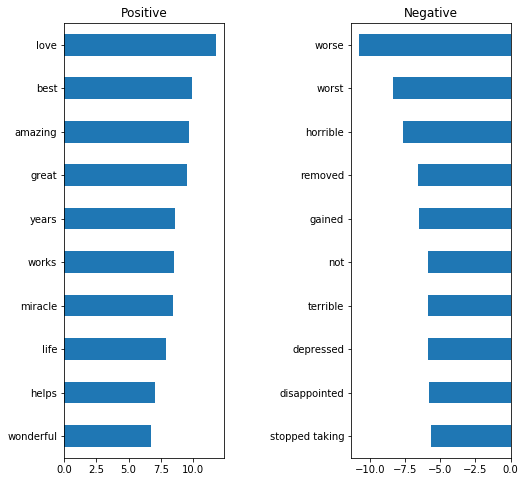

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1]) #counts backwards 
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');
#Copied this shell of a graph
#keep this for further notice
#we can see that the positive words are often words we use subjectively, yet options like "years" are unable to be catagoried right awa
#they may take a positive or negative turn dep

## What I could have done better 

1) Used lemmetization (Worse and Worst would be combined)
2) Used performance metric besides accuracy 
4) Applied it to actual test set
5) could have expanded on "usefulCount"
    - could have eliminated ones that just have one occurence and evualated from there 
6) Added another model to predict (wanted to do Naive Bayes) 

## Reference

https://github.com/martinpella/metacritic/blob/master/sentiment.ipynb